# CE7454 Project - Group 01
# Sleep stages classification using EEG signals
### Emadeldeen Ahmed, Lotfi Ismail, Rakaraddi Appan

The link to our GitHub repository is [here](https://github.com/ismail0T/CE7454_project).


# Part I: Motivation
Sleep-wake classification is important for measuring the sleep quality as it significantly affects the quality of daily life and it helps in finding out sleep disorders. A lot of studies have been made in this field but most of them used hand-crafted features extraction which may lead to less accurate classification results and longer processing time. However, some new deep learning models can also be deployed to achieve better accuracy and faster results.

# Part II: Dataset Exploration
We will start by exploring and exploiting a public sleep EEG dataset, Physionet, which can be downloaded from [Physionet website](https://physionet.org/physiobank/database/sleep-edfx/). The dataset contains 78 whole-night PSG data and the corresponding hypnograms (sleep patterns).

PSG recordings include Electroencephalogram (EEG), Electrooculogram (EOG), Electromyogram (EMG) and Electrocardiogram (ECG) recordings [[1]](https://www.sciencedirect.com/science/article/pii/S0925231212008387). These PSG data can be classified as wake(W), Rapid Eye Movement (REM) sleep and Non-REM. Non-REM sleep is further divided into stages 1, 2, 3 and 4 [[2]](https://www.ncbi.nlm.nih.gov/pubmed/25629798). As indicated in the literature, the EEG are the most important and frequently used signals for analyzing sleep staging and many researches uses single-channel EEG to help reducing the sleep disturbances caused by PSG recording equipment.
In this analysis, we will explore using the same channel mentioned in the literature as well as using another channel besides. 
Note that we have tried using EOG recordings instead of EEG but didn't achieve better results.

In [1]:
import os
import random
import warnings
warnings.filterwarnings('ignore')
import datetime
import ntpath
from itertools import chain, repeat
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import mne
from mne.io import read_raw_edf
from mne import viz

from bokeh.io import output_notebook
output_notebook()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from Utils import *
from NN_Utils import *

Loading BokehJS ...

In [ ]:
f = open('download_physionet_13.sh', 'r')
save_path = "/home/ismail/Dev/data_2013"
if not os.path.exists(save_path):
    os.makedirs(save_path)
lines = f.read()

for url in lines.split('\n'):
    file_name = url.split("/")[-1]
    file_save_path = os.path.join(save_path, file_name)
    urllib.request.urlretrieve(url,file_save_path)
print("Dataset is download successfully !!!")

In [3]:
ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

sampling_rate = 100.0
EPOCH_SEC_SIZE = 30

In [25]:
data_path = '/home/ismail/Dev/data_2013'
# single subject
data_files = os.listdir(data_path)

edf_data_files = [i for i in data_files if "-PSG" in i]
hyp_data_files = [i for i in data_files if "Hypnogram" in i]

edf_files_path = os.path.join(data_path, edf_data_files[10])
hyp_files_path = os.path.join(data_path, hyp_data_files[10])

print(f"Number of PSG files used in analysis:       {len(edf_data_files)} files")
print(f"Number of hypnogram files used in analysis: {len(hyp_data_files)} files")

Number of PSG files used in analysis:       39 files
Number of hypnogram files used in analysis: 39 files


In [12]:
class_duration = {0:0,1:0,2:0,3:0,4:0}

for i in range(len(edf_data_files)):
#     psg_files_path = os.path.join(data_path, edf_data_files[i])
    hyp_files_path = os.path.join(data_path, hyp_data_files[i])
    
    # Read annotation and its header
    f = open(hyp_files_path, 'r', errors='ignore')
    reader_ann = BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header
    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = datetime.datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    file_duration_in_sec = ann[0][len(ann[0])-1][0] + ann[0][len(ann[0])-1][1]
    
    # Generate label and remove indices
    count = 0
    for a in ann[0]:
        onset_sec, duration_sec, ann_char = a
        ann_str = ann_char[0][2:-1]
        label = ann2label[ann_str]
        if label != UNKNOWN:
            if duration_sec % EPOCH_SEC_SIZE != 0:
                raise Exception("Something wrong")
            class_duration[label] += duration_sec
            count+=1


In [20]:
x = class_duration
import math
from bokeh.io import output_file, show
from bokeh.palettes import Category20c
from bokeh.palettes import Spectral6
from bokeh.plotting import figure
from bokeh.transform import cumsum
import pandas as pd
data = pd.Series(x).reset_index(name='value').rename(columns={'index':'class'})
data['angle'] = data['value']/data['value'].sum() * 2*math.pi
data['color'] = Category20c[len(x)]

p = figure(plot_height=350, title="Pie Chart", toolbar_location=None,
        tools="hover", tooltips="@class: @value")

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='Class', source=data)
show(p)

In [27]:
raw = read_raw_edf(edf_files_path, preload=True, stim_channel=None, verbose=False)

from bokeh.layouts import gridplot
from bokeh.plotting import figure

# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']

data = {}
times = {}
ch_names = {}
for ch in range(len(raw.info["chs"])): # 7 channels
    ch_names[ch] = raw.info["chs"][ch]['ch_name']
    data[ch], times[ch] = raw[ch, int(sfreq * 1):int(sfreq * 10)]

#data_1, times_1 = raw[1, int(sfreq * 1):int(sfreq * 10)]

# for i in range(len(raw.info["chs"])):
#     fig = plt.subplots(figsize=(10,8))
#     plt.plot(times[i], data[i].T)
#     plt.xlabel('Seconds')
#     plt.ylabel('$\mu V$')
#     plt.legend([ch_names[i]])
#     plt.show()


# create three plots
ss = []
for i in range(7):
    s = figure()
    s.line(times[i], data[i].squeeze(), color='navy', alpha=0.5, legend=[ch_names[i]])
    ss.append(s)
    
# s2 = figure()
# s2.line(times[1], data[1].squeeze(), color='navy', alpha=0.5, legend=[ch_names[1]])
# s3 = figure()
# s3.line(times[2], data[2].squeeze(), color='navy', alpha=0.5, legend=[ch_names[2]])
# make a grid
grid = gridplot(ss, ncols=1, plot_width=900, plot_height=250)

# show the results
show(grid)

# Part III: Dataset Preprocessing


In [ ]:
# %run -i 'prepare_physionet.py' 

# Part IV: Models
Since our dataset suffer from the imbalance problem, we will train our models on the data before and after oversampling.

In [2]:
# Global variables

classes = ['W', 'N1', 'N2', 'N3', 'REM']
n_classes = len(classes)
device = torch.device("cuda:1")
num_folds = 20

## Section A: Before oversampling

In [3]:
# Data Folder
data_dir_eeg = "../data_2013/eeg_fpz_cz"

### 1. MLP

In [4]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.n_classes = 5

        self.layer1 = nn.Linear(3000, 256, bias=False)
        self.layer2 = nn.Linear(256, self.n_classes, bias=False)

    def forward(self, x):
        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        y = self.layer1(x)
        y = F.relu(y)

        scores = self.layer2(y)

        return  scores

In [5]:
model = MLP()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         768,000
            Linear-2                    [-1, 5]           1,280
Total params: 769,280
Trainable params: 769,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.93
Estimated Total Size (MB): 2.95
----------------------------------------------------------------


In [6]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=False)
torch.save(confusion_matrix, 'conf_MLP.pt')
np.savez("train_MLP", train_history_over_CV)
np.savez("val_MLP", val_history_over_CV)

num_folds:  20  num_epochs:  30
Train Data Shape:  (39680, 1, 3000)   Test Data Shape:  (2560, 1, 3000)


__Train  W 7442  =>  775
__Train  N1 2704  =>  100
__Train  N2 16705  =>  1094
__Train  N3 5379  =>  324
__Train  REM 7450  =>  267

Fold <1>
There are 769280 (0.77 million) parameters in this neural network
Epoch [1/30] , Accuracy :  42.25806451612903
Test Accuracy: 43.5546875 %


Epoch [2/30] , Accuracy :  50.0554435483871
Test Accuracy: 45.0390625 %


Epoch [3/30] , Accuracy :  56.67590725806452
Test Accuracy: 44.8828125 %


Epoch [4/30] , Accuracy :  62.986391129032256
Test Accuracy: 45.7421875 %


Epoch [5/30] , Accuracy :  69.36995967741936
Test Accuracy: 45.3515625 %


Epoch [6/30] , Accuracy :  74.56653225806451
Test Accuracy: 44.9609375 %


Epoch [7/30] , Accuracy :  79.08266129032258
Test Accuracy: 43.515625 %


Epoch [8/30] , Accuracy :  82.21774193548387
Test Accuracy: 43.0859375 %


Epoch [9/30] , Accuracy :  84.63457661290322
Test Accuracy: 41.796875 %


Epoch [10/30]

Epoch [6/30] , Accuracy :  72.91337025316456
Test Accuracy: 41.94711538461539 %


Epoch [7/30] , Accuracy :  77.17068829113924
Test Accuracy: 41.28605769230769 %


Epoch [8/30] , Accuracy :  80.96321202531645
Test Accuracy: 40.68509615384615 %


Epoch [9/30] , Accuracy :  83.57397151898735
Test Accuracy: 40.50480769230769 %


Epoch [10/30] , Accuracy :  85.00791139240506
Test Accuracy: 40.26442307692308 %


Epoch [11/30] , Accuracy :  86.55310522151899
Test Accuracy: 38.04086538461539 %


Epoch [12/30] , Accuracy :  87.56428006329115
Test Accuracy: 37.56009615384615 %


Epoch [13/30] , Accuracy :  88.9932753164557
Test Accuracy: 37.800480769230774 %


Epoch [14/30] , Accuracy :  89.67810522151899
Test Accuracy: 39.543269230769226 %


Epoch [15/30] , Accuracy :  90.0810917721519
Test Accuracy: 38.762019230769226 %


Epoch [16/30] , Accuracy :  90.67691851265823
Test Accuracy: 38.34134615384615 %


Epoch [17/30] , Accuracy :  90.99584651898735
Test Accuracy: 39.90384615384615 %


Epoch [

Epoch [11/30] , Accuracy :  86.72123805732484
Test Accuracy: 38.59375 %


Epoch [12/30] , Accuracy :  87.27607484076432
Test Accuracy: 39.84375 %


Epoch [13/30] , Accuracy :  88.62708996815286
Test Accuracy: 39.947916666666664 %


Epoch [14/30] , Accuracy :  89.46307722929936
Test Accuracy: 40.15625 %


Epoch [15/30] , Accuracy :  90.11992436305732
Test Accuracy: 40.416666666666664 %


Epoch [16/30] , Accuracy :  90.98079219745223
Test Accuracy: 39.895833333333336 %


Epoch [17/30] , Accuracy :  90.83648487261146
Test Accuracy: 40.572916666666664 %


Epoch [18/30] , Accuracy :  91.24701433121018
Test Accuracy: 41.041666666666664 %


Epoch [19/30] , Accuracy :  91.64759156050955
Test Accuracy: 40.572916666666664 %


Epoch [20/30] , Accuracy :  91.99343152866241
Test Accuracy: 41.5625 %


Epoch [21/30] , Accuracy :  92.24970143312102
Test Accuracy: 38.75 %


Epoch [22/30] , Accuracy :  92.54826831210191
Test Accuracy: 40.0 %


Epoch [23/30] , Accuracy :  93.23248407643312
Test Accuracy:

Epoch [20/30] , Accuracy :  92.01777156549521
Test Accuracy: 37.95955882352941 %


Epoch [21/30] , Accuracy :  92.22494009584665
Test Accuracy: 37.95955882352941 %


Epoch [22/30] , Accuracy :  92.65674920127796
Test Accuracy: 37.13235294117647 %


Epoch [23/30] , Accuracy :  93.10353434504792
Test Accuracy: 36.626838235294116 %


Epoch [24/30] , Accuracy :  93.59774361022363
Test Accuracy: 37.775735294117645 %


Epoch [25/30] , Accuracy :  93.63019169329073
Test Accuracy: 37.54595588235294 %


Epoch [26/30] , Accuracy :  93.71006389776358
Test Accuracy: 37.91360294117647 %


Epoch [27/30] , Accuracy :  94.01956869009584
Test Accuracy: 37.91360294117647 %


Epoch [28/30] , Accuracy :  94.43390575079871
Test Accuracy: 37.362132352941174 %


Epoch [29/30] , Accuracy :  94.37649760383387
Test Accuracy: 37.68382352941176 %


Epoch [30/30] , Accuracy :  94.68101038338658
Test Accuracy: 38.373161764705884 %


__Train  W 7849  =>  313
__Train  N1 2590  =>  204
__Train  N2 16716  =>  1081
__Tr

Epoch [27/30] , Accuracy :  93.54717548076923
Test Accuracy: 46.13970588235294 %


Epoch [28/30] , Accuracy :  93.75500801282051
Test Accuracy: 46.185661764705884 %


Epoch [29/30] , Accuracy :  94.17568108974359
Test Accuracy: 48.80514705882353 %


Epoch [30/30] , Accuracy :  94.50120192307693
Test Accuracy: 46.737132352941174 %


__Train  W 7907  =>  310
__Train  N1 2641  =>  163
__Train  N2 16566  =>  1233
__Train  N3 5462  =>  241
__Train  REM 7232  =>  485

Fold <14>
Epoch [1/30] , Accuracy :  41.298231511254016
Test Accuracy: 47.53289473684211 %


Epoch [2/30] , Accuracy :  49.21121382636656
Test Accuracy: 49.09539473684211 %


Epoch [3/30] , Accuracy :  55.55918408360129
Test Accuracy: 48.88980263157895 %


Epoch [4/30] , Accuracy :  61.751406752411576
Test Accuracy: 47.162828947368425 %


Epoch [5/30] , Accuracy :  67.75773713826366
Test Accuracy: 44.819078947368425 %


Epoch [6/30] , Accuracy :  73.11093247588425
Test Accuracy: 44.037828947368425 %


Epoch [7/30] , Accuracy : 

Epoch [1/30] , Accuracy :  41.24060522151899
Test Accuracy: 44.95192307692308 %


Epoch [2/30] , Accuracy :  48.88993275316456
Test Accuracy: 43.75 %


Epoch [3/30] , Accuracy :  54.989121835443036
Test Accuracy: 44.59134615384615 %


Epoch [4/30] , Accuracy :  61.07842167721519
Test Accuracy: 45.793269230769226 %


Epoch [5/30] , Accuracy :  67.2146954113924
Test Accuracy: 44.89182692307692 %


Epoch [6/30] , Accuracy :  72.4881329113924
Test Accuracy: 44.47115384615385 %


Epoch [7/30] , Accuracy :  77.1632713607595
Test Accuracy: 43.14903846153847 %


Epoch [8/30] , Accuracy :  80.6220332278481
Test Accuracy: 44.050480769230774 %


Epoch [9/30] , Accuracy :  83.16604034810126
Test Accuracy: 42.06730769230769 %


Epoch [10/30] , Accuracy :  84.81012658227847
Test Accuracy: 42.24759615384615 %


Epoch [11/30] , Accuracy :  86.42701740506328
Test Accuracy: 40.68509615384615 %


Epoch [12/30] , Accuracy :  87.71756329113924
Test Accuracy: 42.84855769230769 %


Epoch [13/30] , Accuracy :

Epoch [7/30] , Accuracy :  76.79711687306502
Test Accuracy: 46.205357142857146 %


Epoch [8/30] , Accuracy :  80.2873452012384
Test Accuracy: 45.424107142857146 %


Epoch [9/30] , Accuracy :  82.92134287925697
Test Accuracy: 45.424107142857146 %


Epoch [10/30] , Accuracy :  84.46691176470588
Test Accuracy: 45.3125 %


Epoch [11/30] , Accuracy :  86.48171439628483
Test Accuracy: 44.86607142857143 %


Epoch [12/30] , Accuracy :  87.17105263157895
Test Accuracy: 44.97767857142857 %


Epoch [13/30] , Accuracy :  87.97407120743034
Test Accuracy: 44.754464285714285 %


Epoch [14/30] , Accuracy :  89.0141253869969
Test Accuracy: 46.651785714285715 %


Epoch [15/30] , Accuracy :  89.093943498452
Test Accuracy: 47.879464285714285 %


Epoch [16/30] , Accuracy :  89.60913312693498
Test Accuracy: 45.982142857142854 %


Epoch [17/30] , Accuracy :  89.7953753869969
Test Accuracy: 46.763392857142854 %


Epoch [18/30] , Accuracy :  90.60565015479877
Test Accuracy: 49.888392857142854 %


Epoch [19/30]

Epoch: 1  max_acc= 44.758011809184595


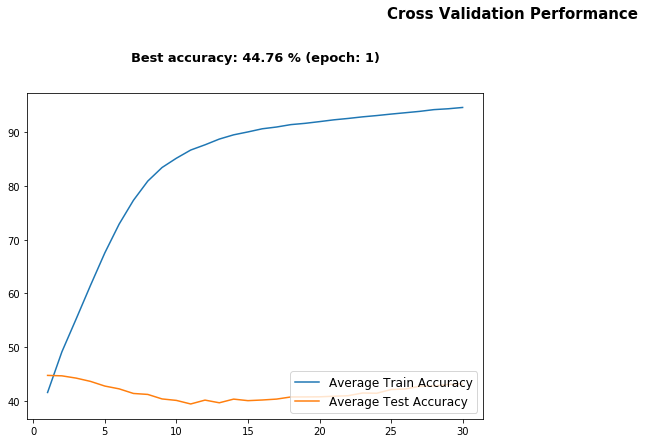

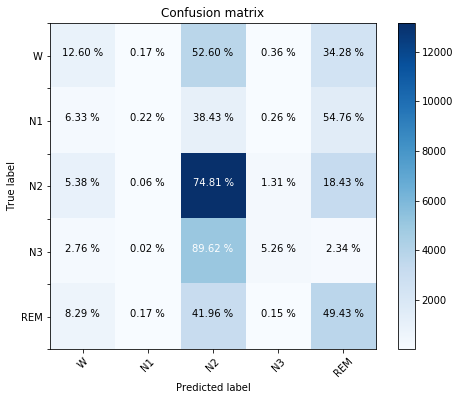

Acc  W 12.60 %
Acc  N1 0.22 %
Acc  N2 74.81 %
Acc  N3 5.26 %
Acc  REM 49.43 %


In [7]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 2. Conv1D

In [8]:
class ConvSimple(nn.Module):

    def __init__(self):
        super(ConvSimple, self).__init__()
        self.n_classes = 5
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.AvgPool1d(2, stride=6)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(2, stride=2)

        self.conv5 = nn.Conv1d(64, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool_avg = nn.AvgPool1d(2)

        self.linear1 = nn.Linear(3328, 128)

        self.dropout1 = nn.Dropout(0.2)

        # LL2:   128  -->  classes
        self.linear2 = nn.Linear(128, self.n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool_avg(x)
        x = self.dropout1(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))
        # print(x.shape)  # 24'064

        x = self.linear1(x)
        x = F.relu(x)

        # Droput
        x = self.dropout1(x)

        # LL2:   128  -->  classes
        x = self.linear2(x)

        return x

In [9]:
model = ConvSimple()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
            Conv1d-2              [-1, 32, 331]          10,272
         AvgPool1d-3               [-1, 32, 55]               0
           Dropout-4               [-1, 32, 55]               0
            Conv1d-5               [-1, 64, 55]           6,208
            Conv1d-6               [-1, 64, 55]          12,352
         AvgPool1d-7               [-1, 64, 27]               0
           Dropout-8               [-1, 64, 27]               0
            Conv1d-9              [-1, 256, 27]          49,408
           Conv1d-10              [-1, 256, 27]         196,864
        AvgPool1d-11              [-1, 256, 13]               0
          Dropout-12              [-1, 256, 13]               0
           Linear-13                  [-1, 128]         426,112
          Dropout-14                  [

In [10]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=False)
torch.save(confusion_matrix, 'conf_Conv.pt')
np.savez("train_Conv", train_history_over_CV)
np.savez("val_Conv", val_history_over_CV)

num_folds:  20  num_epochs:  30
Train Data Shape:  (39680, 1, 3000)   Test Data Shape:  (2560, 1, 3000)


__Train  W 7442  =>  775
__Train  N1 2704  =>  100
__Train  N2 16705  =>  1094
__Train  N3 5379  =>  324
__Train  REM 7450  =>  267

Fold <1>
There are 702213 (0.70 million) parameters in this neural network
Epoch [1/30] , Accuracy :  41.849798387096776
Test Accuracy: 42.734375 %


Epoch [2/30] , Accuracy :  43.47530241935484
Test Accuracy: 58.7890625 %


Epoch [3/30] , Accuracy :  54.465725806451616
Test Accuracy: 55.1171875 %


Epoch [4/30] , Accuracy :  56.95312500000001
Test Accuracy: 65.390625 %


Epoch [5/30] , Accuracy :  60.526713709677416
Test Accuracy: 68.3203125 %


Epoch [6/30] , Accuracy :  63.19556451612903
Test Accuracy: 64.375 %


Epoch [7/30] , Accuracy :  65.07308467741936
Test Accuracy: 69.1015625 %


Epoch [8/30] , Accuracy :  66.03830645161291
Test Accuracy: 63.6328125 %


Epoch [9/30] , Accuracy :  66.84727822580645
Test Accuracy: 68.984375 %


Epoch [10/30] ,

Epoch [6/30] , Accuracy :  65.17503955696202
Test Accuracy: 64.7235576923077 %


Epoch [7/30] , Accuracy :  67.16277689873418
Test Accuracy: 68.8701923076923 %


Epoch [8/30] , Accuracy :  69.28896360759494
Test Accuracy: 70.4326923076923 %


Epoch [9/30] , Accuracy :  69.76117484177216
Test Accuracy: 70.13221153846155 %


Epoch [10/30] , Accuracy :  71.92197389240506
Test Accuracy: 77.4639423076923 %


Epoch [11/30] , Accuracy :  72.93067642405063
Test Accuracy: 77.28365384615384 %


Epoch [12/30] , Accuracy :  73.76631724683544
Test Accuracy: 73.97836538461539 %


Epoch [13/30] , Accuracy :  74.53273338607595
Test Accuracy: 78.06490384615384 %


Epoch [14/30] , Accuracy :  75.09642009493672
Test Accuracy: 72.65625 %


Epoch [15/30] , Accuracy :  75.0840585443038
Test Accuracy: 73.37740384615384 %


Epoch [16/30] , Accuracy :  76.47596914556962
Test Accuracy: 75.24038461538461 %


Epoch [17/30] , Accuracy :  76.37460443037975
Test Accuracy: 72.35576923076923 %


Epoch [18/30] , Accura

Epoch [12/30] , Accuracy :  74.59444665605095
Test Accuracy: 77.76041666666667 %


Epoch [13/30] , Accuracy :  75.218949044586
Test Accuracy: 78.28125 %


Epoch [14/30] , Accuracy :  75.74890525477707
Test Accuracy: 78.22916666666667 %


Epoch [15/30] , Accuracy :  76.18929140127389
Test Accuracy: 78.48958333333333 %


Epoch [16/30] , Accuracy :  76.46795382165605
Test Accuracy: 78.75 %


Epoch [17/30] , Accuracy :  76.89092356687898
Test Accuracy: 79.53125 %


Epoch [18/30] , Accuracy :  77.31389331210191
Test Accuracy: 78.95833333333333 %


Epoch [19/30] , Accuracy :  77.54528264331209
Test Accuracy: 79.94791666666666 %


Epoch [20/30] , Accuracy :  78.10011942675159
Test Accuracy: 78.80208333333333 %


Epoch [21/30] , Accuracy :  78.53055334394905
Test Accuracy: 77.91666666666667 %


Epoch [22/30] , Accuracy :  78.70720541401273
Test Accuracy: 78.69791666666667 %


Epoch [23/30] , Accuracy :  79.14510350318471
Test Accuracy: 79.0625 %


Epoch [24/30] , Accuracy :  79.59046576433121


Epoch [21/30] , Accuracy :  79.79982028753993
Test Accuracy: 77.84926470588235 %


Epoch [22/30] , Accuracy :  79.97454073482429
Test Accuracy: 77.80330882352942 %


Epoch [23/30] , Accuracy :  80.5011980830671
Test Accuracy: 78.44669117647058 %


Epoch [24/30] , Accuracy :  80.69588658146965
Test Accuracy: 78.63051470588235 %


Epoch [25/30] , Accuracy :  80.99291134185303
Test Accuracy: 79.09007352941177 %


Epoch [26/30] , Accuracy :  81.3548322683706
Test Accuracy: 79.27389705882352 %


Epoch [27/30] , Accuracy :  81.53204872204472
Test Accuracy: 78.95220588235294 %


Epoch [28/30] , Accuracy :  81.75419329073482
Test Accuracy: 79.41176470588235 %


Epoch [29/30] , Accuracy :  82.21345846645367
Test Accuracy: 79.59558823529412 %


Epoch [30/30] , Accuracy :  82.62529952076677
Test Accuracy: 79.6875 %


__Train  W 7849  =>  313
__Train  N1 2590  =>  204
__Train  N2 16716  =>  1081
__Train  N3 5543  =>  160
__Train  REM 7238  =>  418

Fold <11>
Epoch [1/30] , Accuracy :  41.749298878

Epoch [28/30] , Accuracy :  79.08153044871796
Test Accuracy: 66.86580882352942 %


Epoch [29/30] , Accuracy :  79.12660256410257
Test Accuracy: 66.49816176470588 %


Epoch [30/30] , Accuracy :  79.79266826923077
Test Accuracy: 67.50919117647058 %


__Train  W 7907  =>  310
__Train  N1 2641  =>  163
__Train  N2 16566  =>  1233
__Train  N3 5462  =>  241
__Train  REM 7232  =>  485

Fold <14>
Epoch [1/30] , Accuracy :  41.50673231511254
Test Accuracy: 50.69901315789473 %


Epoch [2/30] , Accuracy :  42.511555466237944
Test Accuracy: 50.74013157894737 %


Epoch [3/30] , Accuracy :  54.21272106109325
Test Accuracy: 56.49671052631579 %


Epoch [4/30] , Accuracy :  61.6634847266881
Test Accuracy: 60.15625 %


Epoch [5/30] , Accuracy :  65.87871784565917
Test Accuracy: 64.80263157894737 %


Epoch [6/30] , Accuracy :  69.64931672025723
Test Accuracy: 70.60032894736842 %


Epoch [7/30] , Accuracy :  71.90514469453376
Test Accuracy: 69.98355263157895 %


Epoch [8/30] , Accuracy :  72.0031149517684

Epoch [2/30] , Accuracy :  45.86876977848101
Test Accuracy: 49.519230769230774 %


Epoch [3/30] , Accuracy :  54.18809335443038
Test Accuracy: 53.66586538461539 %


Epoch [4/30] , Accuracy :  58.3292128164557
Test Accuracy: 59.19471153846154 %


Epoch [5/30] , Accuracy :  61.25148338607595
Test Accuracy: 61.838942307692314 %


Epoch [6/30] , Accuracy :  64.54460047468355
Test Accuracy: 60.036057692307686 %


Epoch [7/30] , Accuracy :  68.23575949367088
Test Accuracy: 61.11778846153846 %


Epoch [8/30] , Accuracy :  71.4992088607595
Test Accuracy: 64.42307692307693 %


Epoch [9/30] , Accuracy :  72.81942246835443
Test Accuracy: 67.36778846153845 %


Epoch [10/30] , Accuracy :  73.64517405063292
Test Accuracy: 69.77163461538461 %


Epoch [11/30] , Accuracy :  74.5821795886076
Test Accuracy: 69.29086538461539 %


Epoch [12/30] , Accuracy :  74.85907832278481
Test Accuracy: 68.8701923076923 %


Epoch [13/30] , Accuracy :  75.41287579113924
Test Accuracy: 68.68990384615384 %


Epoch [14/30]

Epoch [8/30] , Accuracy :  69.36193885448917
Test Accuracy: 68.30357142857143 %


Epoch [9/30] , Accuracy :  70.7623839009288
Test Accuracy: 74.10714285714286 %


Epoch [10/30] , Accuracy :  72.10719814241486
Test Accuracy: 72.54464285714286 %


Epoch [11/30] , Accuracy :  73.3359133126935
Test Accuracy: 77.23214285714286 %


Epoch [12/30] , Accuracy :  74.21391253869969
Test Accuracy: 77.00892857142857 %


Epoch [13/30] , Accuracy :  75.07739938080495
Test Accuracy: 79.57589285714286 %


Epoch [14/30] , Accuracy :  75.75948142414862
Test Accuracy: 80.02232142857143 %


Epoch [15/30] , Accuracy :  76.56733746130031
Test Accuracy: 80.35714285714286 %


Epoch [16/30] , Accuracy :  77.07043343653251
Test Accuracy: 80.69196428571429 %


Epoch [17/30] , Accuracy :  77.74525928792569
Test Accuracy: 81.02678571428571 %


Epoch [18/30] , Accuracy :  78.0185758513932
Test Accuracy: 80.02232142857143 %


Epoch [19/30] , Accuracy :  78.55069659442725
Test Accuracy: 80.24553571428571 %


Epoch [20

Epoch: 25  max_acc= 73.32655468614283


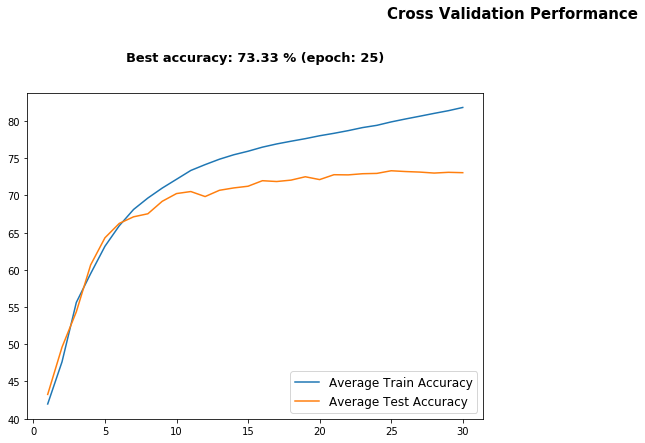

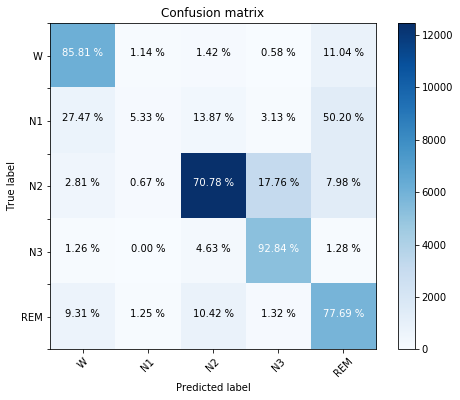

Acc  W 85.81 %
Acc  N1 5.33 %
Acc  N2 70.78 %
Acc  N3 92.84 %
Acc  REM 77.69 %


In [11]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 3. ConvBatchNorm

In [12]:
class ConvBatchNorm(nn.Module):

    def __init__(self):
        super(ConvBatchNorm, self).__init__()
        self.n_classes = 5
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.AvgPool1d(2, stride=6)
        self.bn1 = nn.BatchNorm1d(num_features=32)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(2, stride=2)
        self.bn2 = nn.BatchNorm1d(num_features=64)

        self.conv5 = nn.Conv1d(64, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool_avg = nn.AvgPool1d(2)
        self.bn3 = nn.BatchNorm1d(num_features=256)


        self.linear1 = nn.Linear(3328, 128)

        self.dropout1 = nn.Dropout(0.2)

        self.linear2 = nn.Linear(128, self.n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool_avg(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))

        x = self.linear1(x)
        x = F.relu(x)

        # Droput
        x = self.dropout1(x)

        # LL2:   128  -->  classes
        x = self.linear2(x)

        return x


In [13]:
model = ConvBatchNorm()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 998]             352
       BatchNorm1d-2              [-1, 32, 998]              64
            Conv1d-3              [-1, 32, 331]          10,272
       BatchNorm1d-4              [-1, 32, 331]              64
         AvgPool1d-5               [-1, 32, 55]               0
            Conv1d-6               [-1, 64, 55]           6,208
       BatchNorm1d-7               [-1, 64, 55]             128
            Conv1d-8               [-1, 64, 55]          12,352
       BatchNorm1d-9               [-1, 64, 55]             128
        AvgPool1d-10               [-1, 64, 27]               0
           Conv1d-11              [-1, 256, 27]          49,408
      BatchNorm1d-12              [-1, 256, 27]             512
           Conv1d-13              [-1, 256, 27]         196,864
      BatchNorm1d-14              [-1, 

In [14]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=False)
torch.save(confusion_matrix, 'conf_ConvBatchNorm.pt')
np.savez("train_ConvBatchNorm", train_history_over_CV)
np.savez("val_ConvBatchNorm", val_history_over_CV)

num_folds:  20  num_epochs:  30
Train Data Shape:  (39680, 1, 3000)   Test Data Shape:  (2560, 1, 3000)


__Train  W 7442  =>  775
__Train  N1 2704  =>  100
__Train  N2 16705  =>  1094
__Train  N3 5379  =>  324
__Train  REM 7450  =>  267

Fold <1>
There are 702917 (0.70 million) parameters in this neural network
Epoch [1/30] , Accuracy :  51.585181451612904
Test Accuracy: 42.9296875 %


Epoch [2/30] , Accuracy :  52.22782258064517
Test Accuracy: 63.94531249999999 %


Epoch [3/30] , Accuracy :  58.54838709677419
Test Accuracy: 62.1484375 %


Epoch [4/30] , Accuracy :  62.93598790322581
Test Accuracy: 75.46875 %


Epoch [5/30] , Accuracy :  69.57913306451613
Test Accuracy: 73.59375 %


Epoch [6/30] , Accuracy :  72.20010080645162
Test Accuracy: 74.6875 %


Epoch [7/30] , Accuracy :  75.30493951612904
Test Accuracy: 74.140625 %


Epoch [8/30] , Accuracy :  76.68346774193549
Test Accuracy: 77.734375 %


Epoch [9/30] , Accuracy :  77.72177419354838
Test Accuracy: 75.9765625 %


Epoch [10/30

Epoch [6/30] , Accuracy :  70.35205696202532
Test Accuracy: 76.98317307692307 %


Epoch [7/30] , Accuracy :  72.17414952531645
Test Accuracy: 79.92788461538461 %


Epoch [8/30] , Accuracy :  73.69462025316456
Test Accuracy: 77.82451923076923 %


Epoch [9/30] , Accuracy :  74.88380142405063
Test Accuracy: 80.28846153846155 %


Epoch [10/30] , Accuracy :  75.8084454113924
Test Accuracy: 79.14663461538461 %


Epoch [11/30] , Accuracy :  76.35729825949366
Test Accuracy: 78.84615384615384 %


Epoch [12/30] , Accuracy :  77.26216376582279
Test Accuracy: 72.71634615384616 %


Epoch [13/30] , Accuracy :  77.99396756329115
Test Accuracy: 70.1923076923077 %


Epoch [14/30] , Accuracy :  78.44392800632912
Test Accuracy: 66.16586538461539 %


Epoch [15/30] , Accuracy :  79.20045490506328
Test Accuracy: 66.70673076923077 %


Epoch [16/30] , Accuracy :  79.38340585443038
Test Accuracy: 62.379807692307686 %


Epoch [17/30] , Accuracy :  79.90506329113924
Test Accuracy: 69.53125 %


Epoch [18/30] , Ac

Epoch [12/30] , Accuracy :  76.8859474522293
Test Accuracy: 78.90625 %


Epoch [13/30] , Accuracy :  77.30394108280255
Test Accuracy: 77.5 %


Epoch [14/30] , Accuracy :  77.39102308917197
Test Accuracy: 78.80208333333333 %


Epoch [15/30] , Accuracy :  78.06528662420382
Test Accuracy: 78.4375 %


Epoch [16/30] , Accuracy :  78.53552945859873
Test Accuracy: 79.11458333333333 %


Epoch [17/30] , Accuracy :  78.89878582802548
Test Accuracy: 79.11458333333333 %


Epoch [18/30] , Accuracy :  79.32921974522293
Test Accuracy: 79.84375 %


Epoch [19/30] , Accuracy :  79.66261942675159
Test Accuracy: 78.90625 %


Epoch [20/30] , Accuracy :  80.20252786624204
Test Accuracy: 79.32291666666667 %


Epoch [21/30] , Accuracy :  80.4563097133758
Test Accuracy: 79.21875 %


Epoch [22/30] , Accuracy :  80.98377786624204
Test Accuracy: 78.07291666666667 %


Epoch [23/30] , Accuracy :  81.26990445859873
Test Accuracy: 77.55208333333333 %


Epoch [24/30] , Accuracy :  81.80732484076432
Test Accuracy: 76.5

Epoch [21/30] , Accuracy :  79.88967651757189
Test Accuracy: 80.65257352941177 %


Epoch [22/30] , Accuracy :  80.21914936102237
Test Accuracy: 80.97426470588235 %


Epoch [23/30] , Accuracy :  80.5011980830671
Test Accuracy: 80.79044117647058 %


Epoch [24/30] , Accuracy :  81.01537539936102
Test Accuracy: 81.43382352941177 %


Epoch [25/30] , Accuracy :  81.33736022364218
Test Accuracy: 81.34191176470588 %


Epoch [26/30] , Accuracy :  81.81160143769968
Test Accuracy: 80.83639705882352 %


Epoch [27/30] , Accuracy :  82.11112220447284
Test Accuracy: 80.83639705882352 %


Epoch [28/30] , Accuracy :  82.55041932907349
Test Accuracy: 81.20404411764706 %


Epoch [29/30] , Accuracy :  82.86491613418531
Test Accuracy: 80.92830882352942 %


Epoch [30/30] , Accuracy :  83.2567891373802
Test Accuracy: 80.79044117647058 %


__Train  W 7849  =>  313
__Train  N1 2590  =>  204
__Train  N2 16716  =>  1081
__Train  N3 5543  =>  160
__Train  REM 7238  =>  418

Fold <11>
Epoch [1/30] , Accuracy :  41

Epoch [28/30] , Accuracy :  86.48587740384616
Test Accuracy: 71.50735294117648 %


Epoch [29/30] , Accuracy :  87.01171875
Test Accuracy: 71.32352941176471 %


Epoch [30/30] , Accuracy :  86.7938701923077
Test Accuracy: 72.47242647058823 %


__Train  W 7907  =>  310
__Train  N1 2641  =>  163
__Train  N2 16566  =>  1233
__Train  N3 5462  =>  241
__Train  REM 7232  =>  485

Fold <14>
Epoch [1/30] , Accuracy :  41.39117765273312
Test Accuracy: 50.69901315789473 %


Epoch [2/30] , Accuracy :  44.9030345659164
Test Accuracy: 53.70065789473685 %


Epoch [3/30] , Accuracy :  54.132335209003216
Test Accuracy: 60.60855263157895 %


Epoch [4/30] , Accuracy :  64.35892282958199
Test Accuracy: 67.88651315789474 %


Epoch [5/30] , Accuracy :  69.64680466237942
Test Accuracy: 71.13486842105263 %


Epoch [6/30] , Accuracy :  71.22186495176848
Test Accuracy: 75.28782894736842 %


Epoch [7/30] , Accuracy :  71.74939710610933
Test Accuracy: 75.74013157894737 %


Epoch [8/30] , Accuracy :  73.03557073954

Epoch [2/30] , Accuracy :  42.958860759493675
Test Accuracy: 49.63942307692308 %


Epoch [3/30] , Accuracy :  51.09770569620253
Test Accuracy: 42.96875 %


Epoch [4/30] , Accuracy :  60.13399920886076
Test Accuracy: 50.36057692307693 %


Epoch [5/30] , Accuracy :  66.73259493670885
Test Accuracy: 66.88701923076923 %


Epoch [6/30] , Accuracy :  70.36441851265823
Test Accuracy: 64.60336538461539 %


Epoch [7/30] , Accuracy :  71.87005537974683
Test Accuracy: 63.762019230769226 %


Epoch [8/30] , Accuracy :  72.34721123417721
Test Accuracy: 65.26442307692307 %


Epoch [9/30] , Accuracy :  73.07901503164557
Test Accuracy: 68.32932692307693 %


Epoch [10/30] , Accuracy :  74.1495253164557
Test Accuracy: 69.71153846153845 %


Epoch [11/30] , Accuracy :  75.32387262658227
Test Accuracy: 70.79326923076923 %


Epoch [12/30] , Accuracy :  75.92711629746836
Test Accuracy: 72.83653846153845 %


Epoch [13/30] , Accuracy :  76.54519382911393
Test Accuracy: 72.47596153846155 %


Epoch [14/30] , Accu

Epoch [9/30] , Accuracy :  75.78608746130031
Test Accuracy: 82.36607142857143 %


Epoch [10/30] , Accuracy :  76.45849458204334
Test Accuracy: 82.03125 %


Epoch [11/30] , Accuracy :  77.21071981424149
Test Accuracy: 81.80803571428571 %


Epoch [12/30] , Accuracy :  77.90731424148606
Test Accuracy: 81.58482142857143 %


Epoch [13/30] , Accuracy :  78.37412925696594
Test Accuracy: 81.25 %


Epoch [14/30] , Accuracy :  78.31124226006192
Test Accuracy: 80.58035714285714 %


Epoch [15/30] , Accuracy :  78.86029411764706
Test Accuracy: 81.47321428571429 %


Epoch [16/30] , Accuracy :  79.12151702786377
Test Accuracy: 81.02678571428571 %


Epoch [17/30] , Accuracy :  79.49642027863777
Test Accuracy: 82.03125 %


Epoch [18/30] , Accuracy :  79.78666795665634
Test Accuracy: 81.25 %


Epoch [19/30] , Accuracy :  80.13496517027863
Test Accuracy: 82.36607142857143 %


Epoch [20/30] , Accuracy :  80.3453947368421
Test Accuracy: 82.14285714285714 %


Epoch [21/30] , Accuracy :  80.74932275541795
Te

Epoch: 19  max_acc= 75.30860880900788


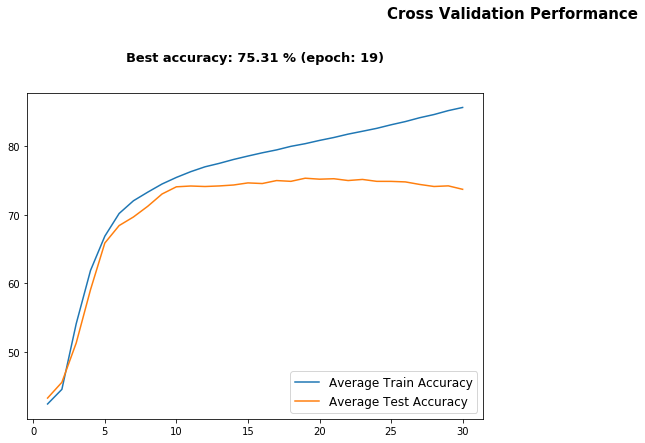

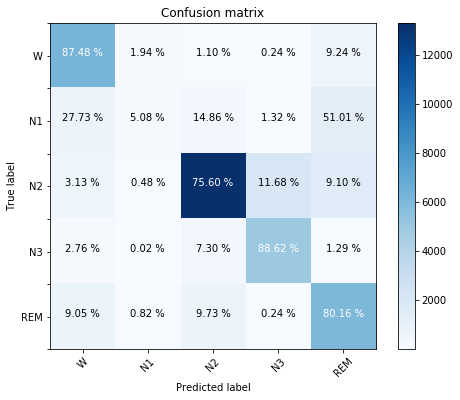

Acc  W 87.48 %
Acc  N1 5.08 %
Acc  N2 75.60 %
Acc  N3 88.62 %
Acc  REM 80.16 %


In [15]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 4. ConvLSTM

In [4]:
class ConvLSTM(nn.Module):

    def __init__(self, bi_dir=False):
        super(ConvLSTM, self).__init__()
        self.n_classes = 5
        self.hidden_dim = 256
        self.bi_dir = bi_dir

        # Conv
        self.conv1 = nn.Conv1d(1, 32, kernel_size=10, padding=1, stride=3)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=10, padding=1, stride=3)
        self.pool1 = nn.MaxPool1d(2, stride=6)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2, stride=2)


        self.linear1 = nn.Linear(1728, 128)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.6)


        # LSTM
        self.lstm_in_dim = 128
        self.lstm = nn.LSTM(self.lstm_in_dim, self.hidden_dim, bidirectional=self.bi_dir)

        # linear
        self.hidden2label1 = nn.Linear(self.hidden_dim * (1 + int(self.bi_dir)), self.n_classes)

    def forward(self, x, h_init, c_init):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout1(x)

        x = x.reshape(x.size(0), x.size(1) * x.size(2))
        # print(x.shape)  # 24'064

        x = self.linear1(x)
        x = F.relu(x)

        # Droput
        x = self.dropout1(x)



        cnn_x = F.relu(x)
        # print('cnn_x', cnn_x.shape)
        # LSTM
        g_seq = cnn_x.unsqueeze(dim=1)
        # print('g_seq', g_seq.shape)

        lstm_out, (h_final, c_final) = self.lstm(g_seq, (h_init, c_init))

        # Droput
        lstm_out = self.dropout2(lstm_out)

        # linear
        cnn_lstm_out = self.hidden2label1(lstm_out)  # activations are implicit

        # output
        scores = cnn_lstm_out

        return scores, h_final, c_final

In [5]:
model = ConvLSTM()
num_epochs = 50
batch_size = 64
learning_rate = 0.04

In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=False)
torch.save(confusion_matrix, 'conf_ConvLSTM.pt')
np.savez("train_ConvLSTM", train_history_over_CV)
np.savez("val_ConvLSTM", val_history_over_CV)

num_folds:  20  num_epochs:  50
Train Data Shape:  (39680, 1, 3000)   Test Data Shape:  (2560, 1, 3000)


__Train  W 7442  =>  775
__Train  N1 2704  =>  100
__Train  N2 16705  =>  1094
__Train  N3 5379  =>  324
__Train  REM 7450  =>  267

Fold <1>
There are 647045 (0.65 million) parameters in this neural network
Epoch [1/50] , Accuracy :  41.658266129032256
Test Accuracy: 42.734375 %


Epoch [2/50] , Accuracy :  42.10685483870968
Test Accuracy: 42.734375 %


Epoch [3/50] , Accuracy :  42.09929435483871
Test Accuracy: 42.734375 %


Epoch [4/50] , Accuracy :  42.07913306451613
Test Accuracy: 42.734375 %


Epoch [5/50] , Accuracy :  42.81502016129032
Test Accuracy: 42.734375 %


Epoch [6/50] , Accuracy :  43.94657258064516
Test Accuracy: 45.703125 %


Epoch [7/50] , Accuracy :  47.366431451612904
Test Accuracy: 67.96875 %


Epoch [8/50] , Accuracy :  53.20312499999999
Test Accuracy: 63.671875 %


Epoch [9/50] , Accuracy :  56.08870967741936
Test Accuracy: 65.0390625 %


Epoch [10/50] , Ac

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

## Section B: After oversampling

In [ ]:
# Data Folder
data_dir_eeg = "../data_2013/traindata_eeg"


### 1. MLP

In [ ]:
model = MLP()
num_epochs = 20
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=True)
torch.save(confusion_matrix, 'conf_MLP_smote.pt')
np.savez("train_MLP_smote", train_history_over_CV)
np.savez("val_MLP_smote", val_history_over_CV)

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 2. Conv1D

In [ ]:
model = ConvSimple()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=True)
torch.save(confusion_matrix, 'conf_Conv_smote.pt')
np.savez("train_Conv_smote", train_history_over_CV)
np.savez("val_Conv_smote", val_history_over_CV)

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 3. ConvBatchNorm

In [ ]:
model = ConvBatchNorm()
num_epochs = 30
batch_size = 128
learning_rate = 0.001

summary(model.cuda(), (1, 3000))

In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=True)
torch.save(confusion_matrix, 'conf_ConvBatchNorm_smote.pt')
np.savez("train_ConvBatchNorm_smote", train_history_over_CV)
np.savez("val_ConvBatchNorm_smote", val_history_over_CV)

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)

### 4. ConvLSTM

In [ ]:
model = ConvLSTM()
num_epochs = 50
batch_size = 64
learning_rate = 0.04

In [ ]:
train_history_over_CV, val_history_over_CV, confusion_matrix = run_experiment_cross_validation(model, data_dir_eeg, num_folds, num_epochs, learning_rate, batch_size, device, smote=True)
torch.save(confusion_matrix, 'conf_ConvLSTM_smote.pt')
np.savez("train_ConvLSTM_smote", train_history_over_CV)
np.savez("val_ConvLSTM_smote", val_history_over_CV)

In [ ]:
plot_CV_history(train_history_over_CV, val_history_over_CV)
plot_confusion_matrix(confusion_matrix.data.numpy(), classes)
print_confusion_matrix_accuracy(confusion_matrix, classes)